# Implementation of DLRM (10%/Faktor 2/APFL) 

## Imports

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [2]:
# Set the seed for reproducibility
np.random.seed(42)

# Total number of rows in the dataset (excluding the header)
total_rows = 1364729

# Number of rows to load - 10% of the total rows
rows_to_load = total_rows // 10

# Generate a sorted list of random indices to skip, aiming to load about 10% of the dataset
skip_rows = np.sort(np.random.choice(np.arange(1, total_rows + 1), size=(total_rows - rows_to_load), replace=False))

# Define the column names
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]

# Load the dataset, skipping the selected rows
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns, skiprows=skip_rows).fillna(0)

# Check the loaded data
print(f"Loaded rows: {len(df)}")

Loaded rows: 136473


In [3]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,e5ba7672,df00d249,0,0,f520f961,0,32c7478e,27b60b01,0,0
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,e5ba7672,2a93f7c8,0,0,5dc9a057,0,32c7478e,90b6276f,0,0
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,8efede7f,5aed7436,21ddcdc9,a458ea53,3c1a8dd8,0,3a171ecb,3fdb382b,b9266ff0,49d68486
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,07c540c4,0f2f9850,5fd56cf9,b1252a9d,96725293,0,32c7478e,2702453c,8b8de563,303cea07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,3486227d,ae09efbe,0,0,80d4b4fb,c9d4222a,423fab69,5ddc2c4c,0,0
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,e5ba7672,6fc84bfb,0,0,5155d8a3,0,423fab69,ded4aac9,0,0
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,d4bb7bd8,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,d4bb7bd8,e4ca448c,0,0,f8af07d5,ad3062eb,32c7478e,9117a34a,0,0


In [4]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,0,0,0,0,0,0,0,0,0,0
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,0,1,1,1,1,0,1,1,1,1
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,0,2,1,1,2,0,1,2,1,1
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,1,3,0,2,3,0,0,3,2,2
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,2,4,2,0,4,0,1,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,8,91,1,1,7735,2,3,81,1,1
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,0,148,1,1,1521,0,3,119,1,1
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,6,475,1,1,70,0,1,16,1,1
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,6,280,1,1,46292,1,1,68,1,1


In [5]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.8177295142629%


In [6]:
# Select halfway point for the split
split_point = len(df) // 2

# Amplify integer features in the first half by multiplying by 2
df.loc[:split_point, 'I1':'I13'] *= 2

# Dampen those integer features in the second half by dividing by 2
df.loc[split_point:, 'I1':'I13'] /= 2

# Now split the DataFrame into two parts: one with amplified features and one with dampened features
df1 = df.iloc[:split_point].reset_index(drop=True)
df2 = df.iloc[split_point:].reset_index(drop=True)

# Verifying the manipulation
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)} - with amplified features")
print(f"df2 records: {len(df2)} - with dampened features")

Total records: 136473
df1 records: 68236 - with amplified features
df2 records: 68237 - with dampened features


In [7]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [8]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [9]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [10]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [11]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 3s 6ms/step - loss: 0.6322 - accuracy: 0.7325 - auc: 0.7287 - val_loss: 0.5683 - val_accuracy: 0.7494 - val_auc: 0.7733
Epoch 2/5
427/427 [==============================] - 2s 5ms/step - loss: 0.5427 - accuracy: 0.7481 - auc: 0.8024 - val_loss: 0.5157 - val_accuracy: 0.7647 - val_auc: 0.8259
Epoch 3/5
427/427 [==============================] - 2s 5ms/step - loss: 0.5059 - accuracy: 0.7610 - auc: 0.8347 - val_loss: 0.4931 - val_accuracy: 0.7728 - val_auc: 0.8424
Epoch 4/5
427/427 [==============================] - 2s 6ms/step - loss: 0.4689 - accuracy: 0.7815 - auc: 0.8602 - val_loss: 0.5162 - val_accuracy: 0.7479 - val_auc: 0.8270
Epoch 5/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4278 - accuracy: 0.8041 - auc: 0.8858 - val_loss: 0.5020 - val_accuracy: 0.7600 - val_auc: 0.8421


In [12]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [13]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.7472 - auc: 0.8182
Loss: 0.5405058264732361, Accuracy: 0.7472295761108398, AUC: 0.8181836605072021


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.632208,0.732505,0.728702,0.568308,0.749359,0.773296
1,0.542698,0.748058,0.802360,0.515663,0.764749,0.825899
2,0.505867,0.761028,0.834672,0.493108,0.772811,0.842368
3,0.468904,0.781545,0.860221,0.516202,0.747893,0.827040
4,0.427782,0.804096,0.885751,0.502007,0.759985,0.842080


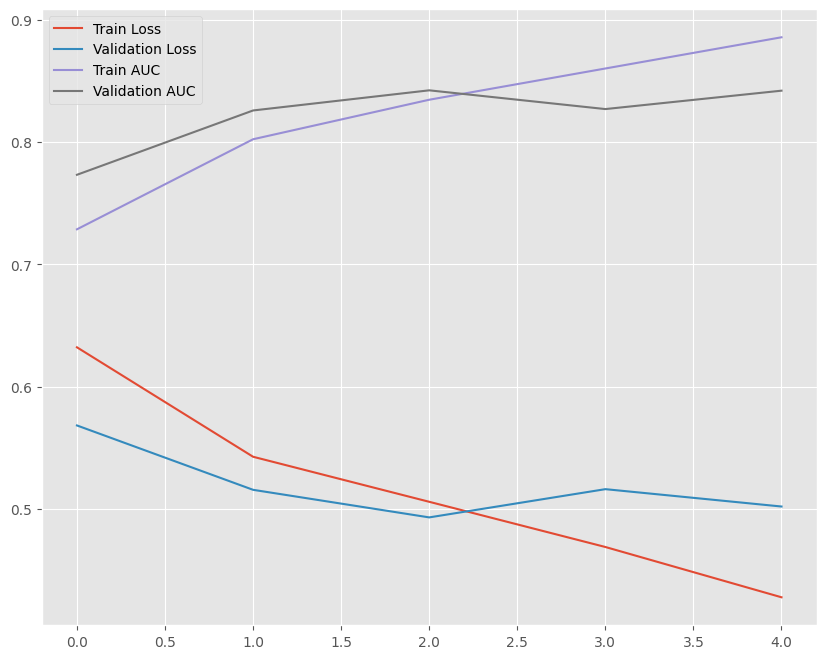

Validation AUC: 0.8516


In [14]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [15]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [16]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:21777


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start..

INFO:     Started server process [2108]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:21777 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=f1c98321839949e4b761388c5fc051b2 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:51584 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [17]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:51586 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:51586 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:51586 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:51586 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51588 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [18]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 16d523d6ca47419e9dfbb2fc0f7fbaa2


In [19]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:51590 - "POST /api/v2/api_call HTTP/1.1" 200 OK
16d523d6ca47419e9dfbb2fc0f7fbaa2


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [20]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:51592 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51586 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [21]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/69d15cb8f2e945bd9980c8309854e619.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=618522ab8eb4468eae0ad589fdca8f9f in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_1436: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:51597 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51599 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_1436
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [22]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:51601 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51586 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51604 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51606 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51608 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51610 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51612 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51614 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51616 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [23]:
request.approve()

INFO:     127.0.0.1:51586 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:51618 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51620 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51622 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51624 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51626 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51628 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51630 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:51632 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 501e2ae931c64ad89baa7e76a654654a changes applied

In [24]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:51586 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [25]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/1cbaedda58a943e598f6570aec17df15.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=9712f77fc6c043dd98c7b86aa1babde9 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_9005: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:51637 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51639 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_9005
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [26]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [27]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [28]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [29]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [30]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 3s 5ms/step - loss: 0.6028 - accuracy: 0.7497 - auc: 0.7561 - val_loss: 0.5311 - val_accuracy: 0.7633 - val_auc: 0.8181
Epoch 2/5
427/427 [==============================] - 2s 5ms/step - loss: 0.5253 - accuracy: 0.7523 - auc: 0.8223 - val_loss: 0.5013 - val_accuracy: 0.7677 - val_auc: 0.8360
Epoch 3/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4908 - accuracy: 0.7659 - auc: 0.8444 - val_loss: 0.4858 - val_accuracy: 0.7772 - val_auc: 0.8470
Epoch 4/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4544 - accuracy: 0.7872 - auc: 0.8688 - val_loss: 0.4806 - val_accuracy: 0.7713 - val_auc: 0.8513
Epoch 5/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4137 - accuracy: 0.8133 - auc: 0.8933 - val_loss: 0.4678 - val_accuracy: 0.7812 - val_auc: 0.8628


In [31]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [32]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 1ms/step - loss: 0.5144 - accuracy: 0.7614 - auc: 0.8360
Loss: 0.5144366025924683, Accuracy: 0.7614250183105469, AUC: 0.8360497355461121


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.602820,0.749656,0.756138,0.531081,0.763283,0.818102
1,0.525289,0.752294,0.822335,0.501318,0.767680,0.836047
2,0.490812,0.765850,0.844432,0.485792,0.777208,0.847017
3,0.454371,0.787228,0.868827,0.480579,0.771345,0.851287
4,0.413659,0.813332,0.893313,0.467783,0.781239,0.862814


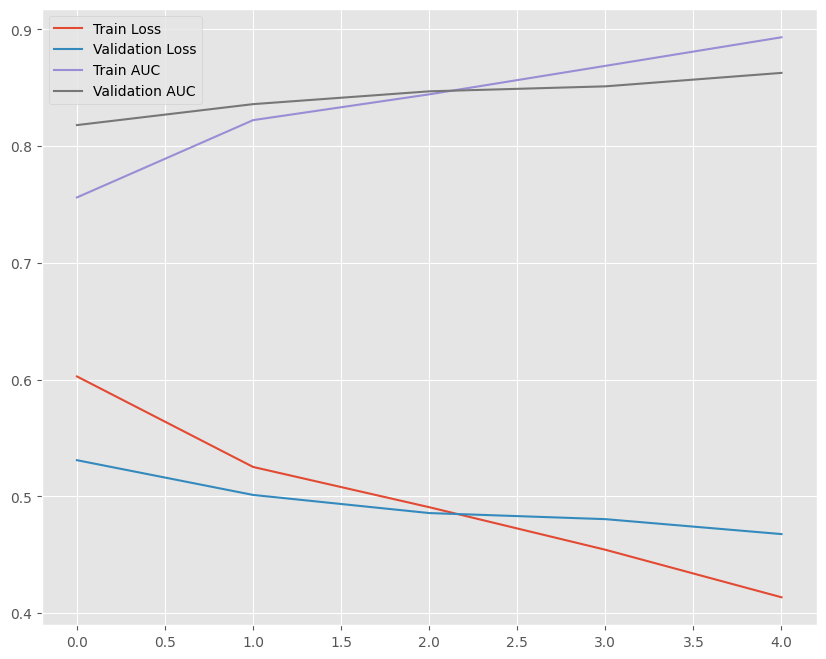

Validation AUC: 0.8572


In [33]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [34]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [35]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:19092


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start..

INFO:     Started server process [2124]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:19092 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=710d4fbb603c4184b63e104870e69d23 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:51679 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [36]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:51681 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:51681 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:51681 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:51681 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51683 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [37]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> b30140a7e81e4f06a55d50b895ed06e6


In [38]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:51685 - "POST /api/v2/api_call HTTP/1.1" 200 OK
b30140a7e81e4f06a55d50b895ed06e6


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [39]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:51687 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51689 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51681 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [40]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/a7b5d931162f414a8e1595def343c4b1.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=0966a406b8c44e1d822584a6f3651dd0 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_244: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:51694 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51696 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_244
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [41]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:51698 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51681 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51700 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51702 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51704 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51706 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51708 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51710 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51712 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [42]:
request.approve()

INFO:     127.0.0.1:51681 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:51714 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51716 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51718 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51720 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51722 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51724 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51726 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:51728 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 777a7d504a0544cfaa65c76af4e2e9b7 changes applied

In [43]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:51681 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [44]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/60490beb8df941f6964e79e0da65dd17.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=6254ac0d936c49f39c465ab5734fc521 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_2305: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:51737 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:51739 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_2305
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [45]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [46]:
weights1 = weights_local
weights2 = weights_local_2

In [47]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [48]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Global Model Weights 

In [49]:
import jax.numpy as jnp

def combine_weights(weights1, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_1 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_1[key] = (alpha * layer_weights1 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_1


In [50]:
global_weights_mix_1 = combine_weights(weights_local, global_weights)

In [51]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [52]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_1:
                sub_layer.set_weights(global_weights_mix_1[sub_layer.name])
    else:
        if layer.name in global_weights_mix_1:
            layer.set_weights(global_weights_mix_1[layer.name])


In [53]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 4s 6ms/step - loss: 0.6114 - accuracy: 0.7383 - auc: 0.7479 - val_loss: 0.5399 - val_accuracy: 0.7596 - val_auc: 0.8019
Epoch 2/5
427/427 [==============================] - 2s 5ms/step - loss: 0.5391 - accuracy: 0.7475 - auc: 0.8045 - val_loss: 0.5510 - val_accuracy: 0.7314 - val_auc: 0.7960
Epoch 3/5
427/427 [==============================] - 2s 5ms/step - loss: 0.5100 - accuracy: 0.7564 - auc: 0.8307 - val_loss: 0.4982 - val_accuracy: 0.7644 - val_auc: 0.8379
Epoch 4/5
427/427 [==============================] - 2s 5ms/step - loss: 0.4698 - accuracy: 0.7780 - auc: 0.8587 - val_loss: 0.4711 - val_accuracy: 0.7908 - val_auc: 0.8576
Epoch 5/5
427/427 [==============================] - 2s 5ms/step - loss: 0.4249 - accuracy: 0.8074 - auc: 0.8871 - val_loss: 0.4864 - val_accuracy: 0.7768 - val_auc: 0.8494


In [54]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [55]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 1ms/step - loss: 0.5360 - accuracy: 0.7522 - auc: 0.8188
Loss: 0.535955548286438, Accuracy: 0.7521750926971436, AUC: 0.818806529045105


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.611399,0.738349,0.747938,0.539873,0.759619,0.801926
1,0.539103,0.747454,0.804475,0.551048,0.731403,0.795977
2,0.510011,0.756393,0.830664,0.498168,0.764383,0.837931
3,0.469824,0.778046,0.858716,0.471079,0.790766,0.857637
4,0.424867,0.807412,0.887144,0.486438,0.776841,0.849398


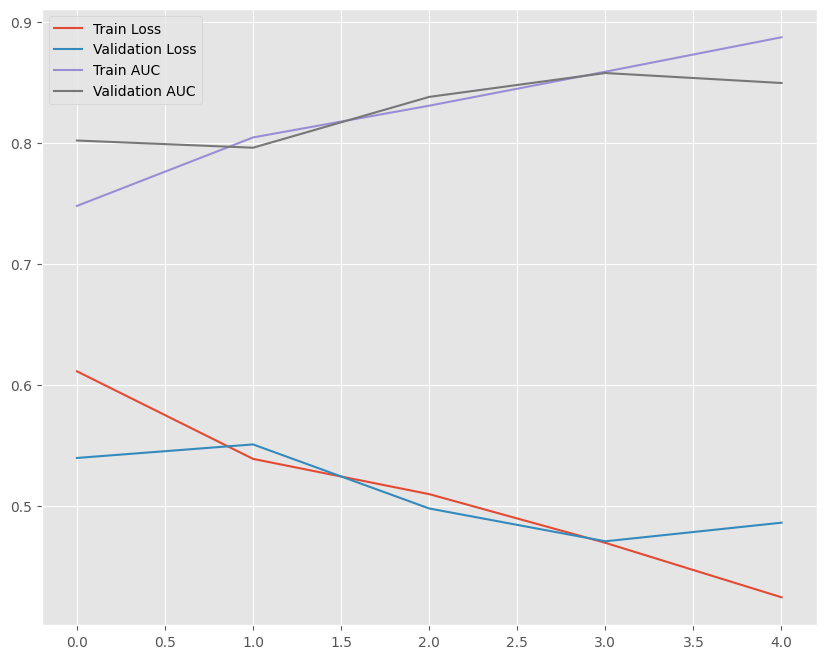

In [56]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [57]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8536


In [58]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 100.58%


# Data Owner 2 with Global Model Weights 

In [59]:
import jax.numpy as jnp

def combine_weights(weights2, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_2 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights2.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights2:
        layer_weights2 = weights2[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights2.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_2[key] = (alpha * layer_weights2 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_2


In [60]:
global_weights_mix_2 = combine_weights(weights2, global_weights)

In [61]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [62]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_2:
                sub_layer.set_weights(global_weights_mix_2[sub_layer.name])
    else:
        if layer.name in global_weights_mix_2:
            layer.set_weights(global_weights_mix_2[layer.name])


In [63]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 3s 6ms/step - loss: 0.6044 - accuracy: 0.7493 - auc: 0.7568 - val_loss: 0.5347 - val_accuracy: 0.7622 - val_auc: 0.8140
Epoch 2/5
427/427 [==============================] - 3s 6ms/step - loss: 0.5364 - accuracy: 0.7493 - auc: 0.8129 - val_loss: 0.5268 - val_accuracy: 0.7457 - val_auc: 0.8188
Epoch 3/5
427/427 [==============================] - 2s 6ms/step - loss: 0.4960 - accuracy: 0.7645 - auc: 0.8410 - val_loss: 0.4834 - val_accuracy: 0.7783 - val_auc: 0.8486
Epoch 4/5
427/427 [==============================] - 2s 6ms/step - loss: 0.4584 - accuracy: 0.7866 - auc: 0.8661 - val_loss: 0.4711 - val_accuracy: 0.7768 - val_auc: 0.8576
Epoch 5/5
427/427 [==============================] - 2s 6ms/step - loss: 0.4180 - accuracy: 0.8103 - auc: 0.8908 - val_loss: 0.4791 - val_accuracy: 0.7812 - val_auc: 0.8545


In [64]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [65]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 2ms/step - loss: 0.5189 - accuracy: 0.7607 - auc: 0.8322
Loss: 0.5189439058303833, Accuracy: 0.7606923580169678, AUC: 0.8322139382362366


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.604445,0.749272,0.756797,0.534720,0.762184,0.814025
1,0.536420,0.749254,0.812872,0.526811,0.745694,0.818786
2,0.495955,0.764458,0.840969,0.483444,0.778307,0.848564
3,0.458390,0.786605,0.866111,0.471085,0.776841,0.857593
4,0.417983,0.810273,0.890780,0.479108,0.781239,0.854453


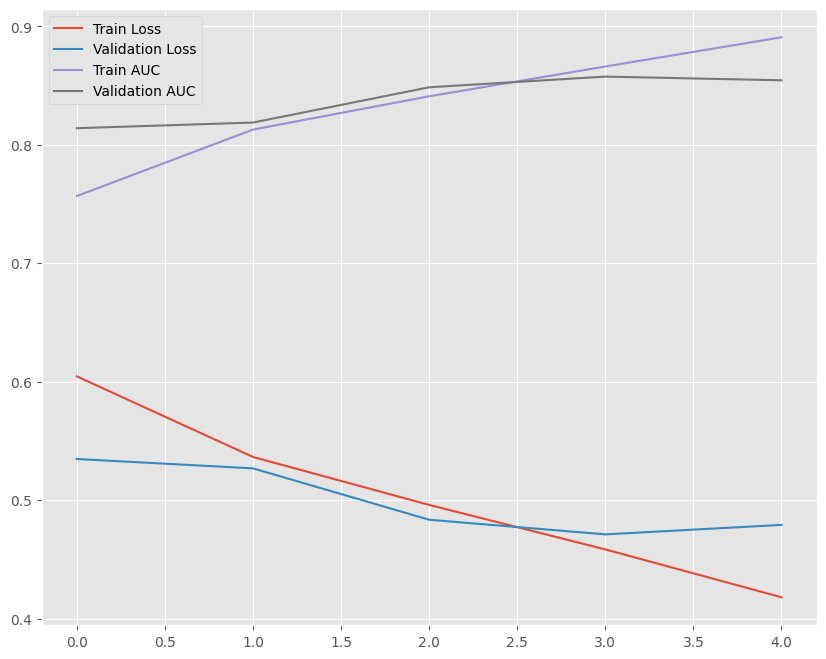

In [66]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [67]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8591


In [68]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 100.53%
